# TODO 

- check other bin
- investigate shear vs reduced shear

In [174]:
import numpy as np
import glob
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [147]:
import numpy as np
from matplotlib import pyplot as plt
import GCRCatalogs
from GCR import GCRQuery
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from scipy.stats import normaltest
from scipy.optimize import curve_fit
import matplotlib.colors as clr
%matplotlib inline
import pickle
import healpy

In [148]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm

from clmm.polaraveraging import compute_shear, make_shear_profile, make_bins
from clmm.plotting import plot_profiles
from clmm.galaxycluster import GalaxyCluster
import clmm.modeling as mod

In [149]:
from magnification_library import *

In [150]:
clmm.__version__

'0.3.0'

In [151]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [152]:
cosmo = extragalactic_cat.cosmology

# Compute profiles for each cluster

In [306]:
bin_path = "halo_pickles_z_0p15/"

In [307]:
cluster_properties = ascii.read(bin_path+"info_halos.txt")

In [308]:
N_clus = cluster_properties['col1'].size
print( "N cluster :", N_clus)
cluster_id_s, cluster_ra_s, cluster_dec_s, cluster_z_s, cluster_mass_s = np.zeros((5,N_clus))

N cluster : 8


In [309]:
cl_s = np.zeros(N_clus,dtype=object)
#cl_mu = np.zeros(N_clus,dtype=object)

In [310]:
mag_cut_s = 25. #for golden sample in i band see https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf p.72
#mag_cut_mu = 26. #26 for completeness in i band see https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf p.72

In [311]:
for j,i in enumerate(sorted(glob.glob(bin_path + "cosmo_DC2_halo_id*"))):
    print (i,j)
    input_catalog = i
    gal_cat = Table(np.load(input_catalog, allow_pickle=True))
    arg = np.argwhere(cluster_properties['col1'] == float((i.split('/')[1]).split('_')[4]))[0][0]
    
    cluster_id_s[j], cluster_ra_s[j], cluster_dec_s[j],cluster_z_s[j], cluster_mass_s[j] = cluster_properties[arg]
    e1, e2 = clmm.utils.convert_shapes_to_epsilon(gal_cat['shear_1'],gal_cat['shear_2'],\
                                              shape_definition='shear',kappa=gal_cat['convergence'])
    col_e1 = Table.Column(name='e1', data=e1)
    col_e2 = Table.Column(name='e2', data=e2)
    col_z = Table.Column(name='z', data=gal_cat['redshift'])
    gal_cat.add_columns([col_e1, col_e2, col_z])
    
    cut_s = (gal_cat['mag_i_lsst']<mag_cut_s)
    #cut_mu = (gal_cat['mag_i_lsst']<mag_cut_mu)
    
    cl_s[j] = GalaxyCluster(str(cluster_id_s[j]), cluster_ra_s[j], cluster_dec_s[j], cluster_z_s[j], gal_cat[cut_s])
    #cl_mu[j] = GalaxyCluster(str(cluster_id_s[j]), cluster_ra_s[j], cluster_dec_s[j], cluster_z_s[j], gal_cat[cut_mu])
    
    tmp = cl_s[j].compute_shear()
    #tmp = cl_mu[j].compute_shear()
    
    print ("done", i)

halo_pickles_z_0p15/cosmo_DC2_halo_id_108700127421_source_list.pickle 0
done halo_pickles_z_0p15/cosmo_DC2_halo_id_108700127421_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_149400129411_source_list.pickle 1
done halo_pickles_z_0p15/cosmo_DC2_halo_id_149400129411_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_167900142421_source_list.pickle 2
done halo_pickles_z_0p15/cosmo_DC2_halo_id_167900142421_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_293100169411_source_list.pickle 3
done halo_pickles_z_0p15/cosmo_DC2_halo_id_293100169411_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_45400180411_source_list.pickle 4
done halo_pickles_z_0p15/cosmo_DC2_halo_id_45400180411_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_4700156411_source_list.pickle 5
done halo_pickles_z_0p15/cosmo_DC2_halo_id_4700156411_source_list.pickle
halo_pickles_z_0p15/cosmo_DC2_halo_id_55300142421_source_list.pickle 6
done halo_pickles_z_0p15/cosmo_DC2_halo_id_5530014242

In [312]:
print( "N cluster :", N_clus)
print( "mean mass M =", round(np.mean(cluster_mass_s),2) ,"x1e14 Msun;", "mean redshift z=", round(np.mean(cluster_z_s),2))

N cluster : 8
mean mass M = 4.56 x1e14 Msun; mean redshift z= 0.19


In [313]:
nbins=20
bins = make_bins(0.2, 20, nbins=nbins, method='evenlog10width')

In [314]:
# Reduced shear

In [315]:
rshear_profiles_s = np.zeros(N_clus,dtype=object)
#shear_profiles_s = np.zeros(N_clus,dtype=object)
mu_profiles_s = np.zeros((N_clus,5),dtype=object)
kappa_profiles_s = np.zeros((N_clus,5),dtype=object)

In [316]:
for i in range(N_clus):
    rshear_profiles_s[i] = cl_s[i].make_shear_profile('radians', 'Mpc', bins = bins, cosmo=cosmo, include_empty_bins=True)
    seps = clmm.utils.convert_units(cl_s[i].galcat["theta"], "radians", "Mpc", redshift=cl_s[i].z, cosmo=cosmo)
    #shear_profiles_s[i,:] = clmm.utils.compute_radial_averages(seps, cl_s[i].galcat['shear'], new_bins, error_model='std/sqrt_n')
    mu_profiles_s[i,:] = clmm.utils.compute_radial_averages(seps, cl_s[i].galcat['magnification'], bins, error_model='std/sqrt_n')
    kappa_profiles_s[i,:] = clmm.utils.compute_radial_averages(seps, cl_s[i].galcat['convergence'], bins, error_model='std/sqrt_n')

/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/utils.py:43: RuntimeWarning: invalid value encountered in true_divide
  yerr = yerr/np.sqrt(binned_statistic(xvals, yvals, statistic='count', bins=xbins)[0])


# Stack the profiles

In [317]:
stacked_radius = []
stacked_gt = []
stacked_mu = []
stacked_shear = []
stacked_kappa = []

for i in range(N_clus):
    stacked_radius.append(rshear_profiles_s[i]['radius'])
    stacked_gt.append(rshear_profiles_s[i]['gt'])
    stacked_mu.append(mu_profiles_s[i,1]) 
    stacked_kappa.append(kappa_profiles_s[i,1]) 
    #stacked_shear


# Construct the models

In [318]:
import pyccl

In [319]:
params = {'h': 0.71, 'Omega_c': 0.22, 'Omega_b': 0.0448, 'sigma8': 0.80, 'n_s': 0.963}

In [320]:
cosmo_ccl = pyccl.core.Cosmology(**params)

In [321]:
concentration = [pyccl.halo_concentration(cosmo_ccl,  cluster_mass_s[i]*1e14, cosmo.scale_factor(cluster_z_s[i]), odelta=200) for i in range(N_clus)]

In [322]:
nan_cond = np.isfinite(np.nanmean(stacked_radius,axis=0))

shear_model = np.zeros((len(cl_s[0].profile['radius'][nan_cond]), N_clus))
kappa_model = np.zeros((len(cl_s[0].profile['radius'][nan_cond]), N_clus))
gt_model = np.zeros((len(cl_s[0].profile['radius'][nan_cond]), N_clus))
mu_model = np.zeros((len(cl_s[0].profile['radius'][nan_cond]), N_clus))


for i in range(N_clus):
    for k in range(len(cl_s[0].profile['radius'][nan_cond])):
    
        shear_model[k,i] = np.mean(mod.predict_tangential_shear(np.nanmean(stacked_radius,axis=0)[nan_cond][k]*cosmo.h,
                                                  cluster_mass_s[i]*1e14*cosmo.h, concentration[i],
                                                  cluster_z_s[i], cl_s[i].galcat['redshift'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))
        
        kappa_model[k,i] = np.mean(mod.predict_convergence(np.nanmean(stacked_radius,axis=0)[nan_cond][k]*cosmo.h,
                                                  cluster_mass_s[i]*1e14*cosmo.h, concentration[i],
                                                  cluster_z_s[i], cl_s[i].galcat['redshift'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

        gt_model[k,i] = np.mean(mod.predict_reduced_tangential_shear(np.nanmean(stacked_radius,axis=0)[nan_cond][k]*cosmo.h,
                                                  cluster_mass_s[i]*1e14*cosmo.h, concentration[i],
                                                  cluster_z_s[i], cl_s[i].galcat['redshift'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

        mu_model[k,i] = np.mean(mod.predict_magnification(np.nanmean(stacked_radius,axis=0)[nan_cond][k]*cosmo.h,
                                                  cluster_mass_s[i]*1e14*cosmo.h, concentration[i],
                                                  cluster_z_s[i], cl_s[i].galcat['redshift'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


# Plot the profiles

/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: R

(0.2, 5)

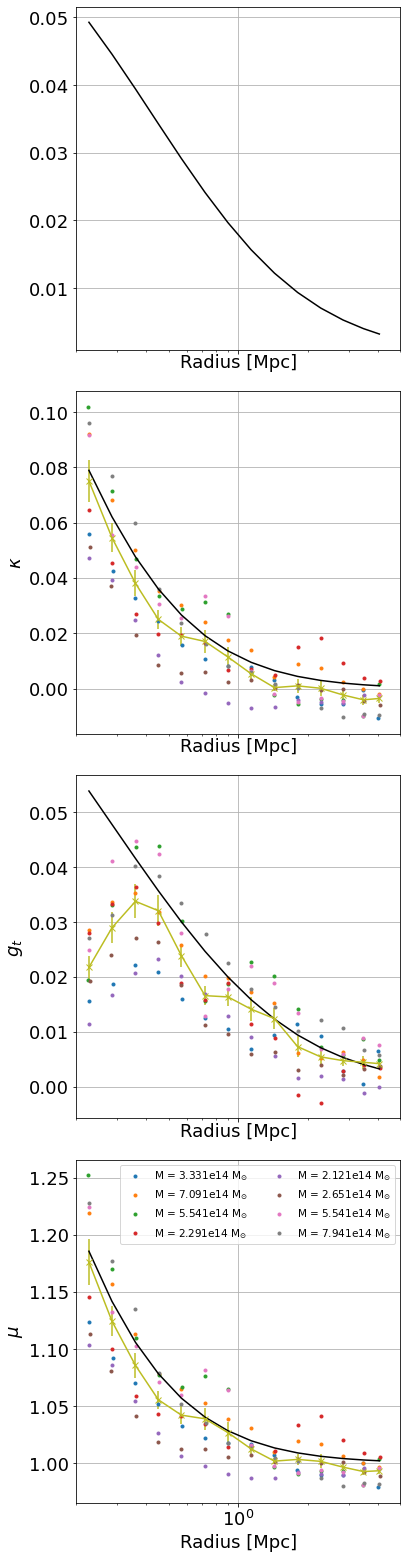

In [323]:
fig, ax = plt.subplots(4,1, figsize=(6,22),sharex=True)

for i in range(N_clus):
    #ax[0].plot(shear_profiles_s[i,0],shear_profiles_s[i,1],'.', label = "M = "+str(round(cluster_mass_s[i],2))+"1e14 M$_{\odot}$")
    ax[1].plot(kappa_profiles_s[i,0],kappa_profiles_s[i,1],'.', label = "M = "+str(round(cluster_mass_s[i],2))+"1e14 M$_{\odot}$")                       
    ax[2].plot(rshear_profiles_s[i]["radius"],rshear_profiles_s[i]["gt"],'.', label = "M = "+str(round(cluster_mass_s[i],2))+"1e14 M$_{\odot}$")
    ax[3].plot(mu_profiles_s[i,0],mu_profiles_s[i,1],'.', label = "M = "+str(round(cluster_mass_s[i],2))+"1e14 M$_{\odot}$")


ax[1].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_kappa,axis=0),yerr = np.nanstd(stacked_kappa,axis=0)/np.sqrt(N_clus),fmt='x-')
ax[2].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_gt,axis=0),yerr = np.nanstd(stacked_gt,axis=0)/np.sqrt(N_clus),fmt='x-')
ax[3].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_mu,axis=0),yerr = np.nanstd(stacked_mu,axis=0)/np.sqrt(N_clus),fmt='x-')


ax[0].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(shear_model,axis=1),'k')
ax[1].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(kappa_model,axis=1),'k')
ax[2].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(gt_model,axis=1),'k')
ax[3].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(mu_model,axis=1),'k')

ax[0].set_xscale('log')  

#ax[0].set_ylabel('$\gamma$')
ax[1].set_ylabel('$\kappa$')
ax[2].set_ylabel('$g_t$')
ax[3].set_ylabel('$\mu$')

[i.set_xlabel('Radius [Mpc]') for i in ax];
[i.grid() for i in ax];

ax[3].legend(ncol=2, fontsize ='xx-small')

fig.tight_layout()


ax[0].set_xlim(0.2,5)

#plt.axvline(2*healpy.nside2resol(4096, arcmin = True)*conv.value, linestyle="dashed")

/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/pbs/throng/lsst/users/mricci/desc/mydesc_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ ==

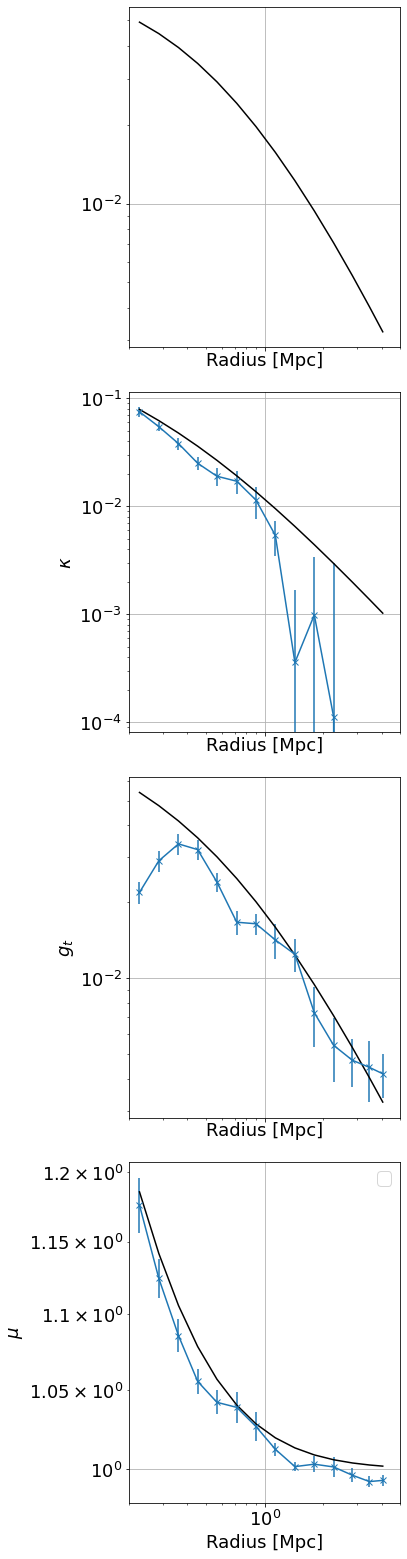

In [324]:
fig, ax = plt.subplots(4,1, figsize=(6,22),sharex=True)

ax[1].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_kappa,axis=0),yerr = np.nanstd(stacked_kappa,axis=0)/np.sqrt(N_clus),fmt='x-')
ax[2].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_gt,axis=0),yerr = np.nanstd(stacked_gt,axis=0)/np.sqrt(N_clus),fmt='x-')
ax[3].errorbar(np.nanmean(stacked_radius,axis=0), np.nanmean(stacked_mu,axis=0),yerr = np.nanstd(stacked_mu,axis=0)/np.sqrt(N_clus),fmt='x-')


ax[0].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(shear_model,axis=1),'k')
ax[1].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(kappa_model,axis=1),'k')
ax[2].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(gt_model,axis=1),'k')
ax[3].plot(np.nanmean(stacked_radius,axis=0)[nan_cond], np.mean(mu_model,axis=1),'k')

ax[0].set_xscale('log')  
ax[0].set_xscale('log')  


#ax[0].set_ylabel('$\gamma$')
ax[1].set_ylabel('$\kappa$')
ax[2].set_ylabel('$g_t$')
ax[3].set_ylabel('$\mu$')

[i.set_xlabel('Radius [Mpc]') for i in ax];
[i.grid() for i in ax];
[i.set_yscale('log') for i in ax ]

ax[3].legend(ncol=2)
ax[0].set_xlim(0.2,5)

fig.tight_layout()
#plt.axvline(2*healpy.nside2resol(4096, arcmin = True)*conv.value, linestyle="dashed")